# Building the models
Before we go ahead and build the models, we might trim the dataset so that most of each team's first 15 games aren't included. Since betting lines weren't included before Feb. 28, 2023, that's when our training data starts. However, we have found that the betting lines aren't strongly correlated with FanDuel and DraftKings points. This means we can go without that data and might have about a season and a half of untouched data we can use for further training if we want to try to improve the model in the future.<br>

For now, we'll just go ahead and use the data we've pulled that started on 2/28/23. For about the first month, the L15 features won't really take 15 games into account. So perhaps we should cut off the dataset to only include games beginning on April 1, 2023. This still gives us the tail-end of the 2023 regular season and playoffs, the full 2023-24 season and the first two months of the 2024-25 season.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import requests
import sqlite3
import re
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
# Connect to your SQLite database
conn = sqlite3.connect('nba_dfs_model.db')

# Query to get the list of all table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Close the connection
conn.close()

# Print the list of table names
table_names = [table[0] for table in tables]
print("Tables in the database:", table_names)

Tables in the database: ['api_players', 'fd_players', 'dk_players', 'game_schedule', 'game_stats', 'sqlite_sequence', 'pace', 'betting_lines', 'merged_data', 'dataset_pre_EDA', 'dataset_with_L15', 'dataset_pre_training']


In [4]:
conn = sqlite3.connect("nba_dfs_model.db")
main_df = pd.read_sql_query("SELECT * FROM dataset_pre_training", conn)
conn.close()
main_df.head()

,id,Name,game_id,player_id,team_id,team,away_team,home_team,home,opponent,...,stl,pts,PF,TOV,usage,mins_share,mins,mins_proj,fd_pts,dk_pts
0,1,Kris Dunn,20230228_SA@UTA,28128078249,29,UTA,SA,UTA,1,SA,...,2.0,11.0,2.0,1.0,14.24,0.107884,26.0,25.892116,21.7,20.25
1,2,Kelly Olynyk,20230228_SA@UTA,28188235349,29,UTA,SA,UTA,1,SA,...,1.0,8.0,1.0,4.0,17.58,0.124481,30.0,29.875519,20.5,22.00
2,3,Udoka Azubuike,20230228_SA@UTA,28818826399,29,UTA,SA,UTA,1,SA,...,0.0,2.0,1.0,0.0,12.71,0.037344,9.0,8.962656,7.4,6.50
3,4,Jeremy Sochan,20230228_SA@UTA,942647035539,27,SA,SA,UTA,0,UTA,...,0.0,13.0,4.0,1.0,21.46,0.117155,28.0,28.117155,28.2,29.00
4,5,Keita Bates-Diop,20230228_SA@UTA,28698359129,27,SA,SA,UTA,0,UTA,...,1.0,6.0,3.0,1.0,10.95,0.142259,34.0,34.142259,21.2,20.00


In [5]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46103 entries, 0 to 46102
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          46103 non-null  int64  
 1   Name        46103 non-null  object 
 2   game_id     46103 non-null  object 
 3   player_id   46103 non-null  object 
 4   team_id     46103 non-null  object 
 5   team        46103 non-null  object 
 6   away_team   46103 non-null  object 
 7   home_team   46103 non-null  object 
 8   home        46103 non-null  int64  
 9   opponent    46103 non-null  object 
 10  date        46103 non-null  object 
 11  PG_FD       46103 non-null  float64
 12  SG_FD       46103 non-null  float64
 13  SF_FD       46103 non-null  float64
 14  PF_FD       46103 non-null  float64
 15  C_FD        46103 non-null  float64
 16  PG_DK       46103 non-null  float64
 17  SG_DK       46103 non-null  float64
 18  SF_DK       46103 non-null  float64
 19  PF_DK       46103 non-nul

In [6]:
main_df['date'] = pd.to_datetime(main_df['date'])

In [7]:
main_df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,46103.0,23052.0,1.0,11526.5,23052.0,34577.5,46103.0,13308.934067
home,46103.0,0.500857,0.0,0.0,1.0,1.0,1.0,0.500005
date,46103,2024-02-01 23:20:19.937965312,2023-02-28 00:00:00,2023-11-14 00:00:00,2024-01-28 00:00:00,2024-04-14 00:00:00,2024-12-23 00:00:00,NaN
PG_FD,46103.0,0.258204,0.0,0.0,0.0,1.0,1.0,0.437652
SG_FD,46103.0,0.421968,0.0,0.0,0.0,1.0,1.0,0.493879
SF_FD,46103.0,0.409778,0.0,0.0,0.0,1.0,1.0,0.491798
PF_FD,46103.0,0.36349,0.0,0.0,0.0,1.0,1.0,0.48101
C_FD,46103.0,0.252305,0.0,0.0,0.0,1.0,1.0,0.43434
PG_DK,46103.0,0.306921,0.0,0.0,0.0,1.0,1.0,0.461222
SG_DK,46103.0,0.378045,0.0,0.0,0.0,1.0,1.0,0.484904


In [8]:
main_df = main_df.sort_values(by = ['team', 'game_id'])

Creating a dataframe showing cumulative game counts for each team.

In [9]:
# Drop duplicates to identify unique games
unique_games = main_df[['team', 'date', 'game_id']].drop_duplicates()

# Create a running game count for unique games
unique_games['running_game_count'] = unique_games.groupby('team').cumcount() + 1


In [10]:
unique_games.head()

,team,date,game_id,running_game_count
86,ATL,2023-02-28,20230228_WAS@ATL,1
617,ATL,2023-03-03,20230303_POR@ATL,2
790,ATL,2023-03-04,20230304_ATL@MIA,3
1109,ATL,2023-03-06,20230306_ATL@MIA,4
1436,ATL,2023-03-08,20230308_ATL@WAS,5


Looking at March 31 running game counts. Still a few 15s here. It looks like this is the last day of 15s. This means that beginning on April 1, each team has played 15 prior games that are included in our dataset and all L15 features take a 15 games into account. 

In [11]:
unique_games[unique_games['date'] == '2023-03-31']

,team,date,game_id,running_game_count
4813,ATL,2023-03-31,20230331_ATL@BKN,16
4815,BKN,2023-03-31,20230331_ATL@BKN,17
4889,BOS,2023-03-31,20230331_UTA@BOS,16
4840,CHA,2023-03-31,20230331_CHI@CHA,15
4841,CHI,2023-03-31,20230331_CHI@CHA,16
4971,CLE,2023-03-31,20230331_NY@CLE,14
4713,DEN,2023-03-31,20230331_DEN@PHO,15
4864,DET,2023-03-31,20230331_DET@HOU,15
4904,GS,2023-03-31,20230331_SA@GS,17
4865,HOU,2023-03-31,20230331_DET@HOU,18


In [12]:
main_df = main_df[main_df['date'] >= '2023-04-01']

In [13]:
main_df.head()

,id,Name,game_id,player_id,team_id,team,away_team,home_team,home,opponent,...,stl,pts,PF,TOV,usage,mins_share,mins,mins_proj,fd_pts,dk_pts
5118,5119,Clint Capela,20230402_DAL@ATL,28218011729,1,ATL,DAL,ATL,1,DAL,...,0.600000,11.933333,1.800000,0.866667,14.247333,0.118486,26.066667,28.436545,33.7,34.25
5119,5120,Trae Young,20230402_DAL@ATL,28978646789,1,ATL,DAL,ATL,1,DAL,...,1.200000,23.266667,1.066667,4.000000,30.863333,0.144243,31.733333,34.618403,46.6,48.25
5120,5121,AJ Griffin,20230402_DAL@ATL,944847615539,1,ATL,DAL,ATL,1,DAL,...,0.181818,6.818182,1.000000,0.454545,22.088182,0.065703,14.454545,15.768696,7.1,8.25
5121,5122,Jalen Johnson,20230402_DAL@ATL,94334276527,1,ATL,DAL,ATL,1,DAL,...,0.375000,5.375000,2.375000,0.625000,16.552500,0.068750,15.125000,16.500106,26.3,24.00
5123,5124,Bogdan Bogdanovic,20230402_DAL@ATL,28628911729,1,ATL,DAL,ATL,1,DAL,...,0.666667,11.866667,1.533333,1.133333,18.172667,0.110607,24.333333,26.545624,21.4,23.50


In [14]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41115 entries, 5118 to 45989
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          41115 non-null  int64         
 1   Name        41115 non-null  object        
 2   game_id     41115 non-null  object        
 3   player_id   41115 non-null  object        
 4   team_id     41115 non-null  object        
 5   team        41115 non-null  object        
 6   away_team   41115 non-null  object        
 7   home_team   41115 non-null  object        
 8   home        41115 non-null  int64         
 9   opponent    41115 non-null  object        
 10  date        41115 non-null  datetime64[ns]
 11  PG_FD       41115 non-null  float64       
 12  SG_FD       41115 non-null  float64       
 13  SF_FD       41115 non-null  float64       
 14  PF_FD       41115 non-null  float64       
 15  C_FD        41115 non-null  float64       
 16  PG_DK       41115 non-nu

In [15]:
main_df.columns

Index(['id', 'Name', 'game_id', 'player_id', 'team_id', 'team', 'away_team',
       'home_team', 'home', 'opponent', 'date', 'PG_FD', 'SG_FD', 'SF_FD',
       'PF_FD', 'C_FD', 'PG_DK', 'SG_DK', 'SF_DK', 'PF_DK', 'C_DK', 'fga',
       'ast', 'tptfgm', 'fgm', 'fta', 'tptfga', 'OffReb', 'ftm', 'blk',
       'DefReb', 'plusMinus', 'stl', 'pts', 'PF', 'TOV', 'usage', 'mins_share',
       'mins', 'mins_proj', 'fd_pts', 'dk_pts'],
      dtype='object')

In [16]:
main_df = main_df.drop(columns = ['team_id', 'away_team', 'home_team', 'home'])

In [17]:
main_df = main_df.set_index(['id', 'Name', 'game_id', 'player_id', 'team', 'opponent', 'date', 'PG_FD', 'SG_FD', 'SF_FD',\
                             'PF_FD', 'C_FD', 'PG_DK', 'SG_DK', 'SF_DK', 'PF_DK', 'C_DK', ])

In [18]:
main_df.head()

,,,,,,,,,,,,,,,,,fga,ast,tptfgm,fgm,fta,tptfga,OffReb,ftm,blk,DefReb,...,stl,pts,PF,TOV,usage,mins_share,mins,mins_proj,fd_pts,dk_pts
id,Name,game_id,player_id,team,opponent,date,PG_FD,SG_FD,SF_FD,PF_FD,C_FD,PG_DK,SG_DK,SF_DK,PF_DK,C_DK,,,,,,,,,,,,,,,,,,,,,
5119,Clint Capela,20230402_DAL@ATL,28218011729,ATL,DAL,2023-04-02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.400000,1.066667,0.000000,5.400000,1.800000,0.000000,3.800000,1.133333,1.066667,6.933333,...,0.600000,11.933333,1.800000,0.866667,14.247333,0.118486,26.066667,28.436545,33.7,34.25
5120,Trae Young,20230402_DAL@ATL,28978646789,ATL,DAL,2023-04-02,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16.600000,9.066667,2.200000,7.266667,7.533333,5.400000,1.066667,6.533333,0.000000,2.133333,...,1.200000,23.266667,1.066667,4.000000,30.863333,0.144243,31.733333,34.618403,46.6,48.25
5121,AJ Griffin,20230402_DAL@ATL,944847615539,ATL,DAL,2023-04-02,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.909091,1.000000,1.000000,2.454545,0.909091,2.818182,0.636364,0.909091,0.454545,1.636364,...,0.181818,6.818182,1.000000,0.454545,22.088182,0.065703,14.454545,15.768696,7.1,8.25
5122,Jalen Johnson,20230402_DAL@ATL,94334276527,ATL,DAL,2023-04-02,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.750000,1.875000,0.375000,2.250000,0.750000,1.375000,0.875000,0.500000,0.125000,4.000000,...,0.375000,5.375000,2.375000,0.625000,16.552500,0.068750,15.125000,16.500106,26.3,24.00
5124,Bogdan Bogdanovic,20230402_DAL@ATL,28628911729,ATL,DAL,2023-04-02,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,8.800000,2.266667,2.333333,4.066667,1.533333,5.466667,0.533333,1.400000,0.400000,1.800000,...,0.666667,11.866667,1.533333,1.133333,18.172667,0.110607,24.333333,26.545624,21.4,23.50


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 

In [20]:
X_FD = main_df.drop(columns = ['fd_pts', 'dk_pts'])
X_DK = main_df.drop(columns = ['fd_pts', 'dk_pts'])

In [21]:
X_FD.columns

Index(['fga', 'ast', 'tptfgm', 'fgm', 'fta', 'tptfga', 'OffReb', 'ftm', 'blk',
       'DefReb', 'plusMinus', 'stl', 'pts', 'PF', 'TOV', 'usage', 'mins_share',
       'mins', 'mins_proj'],
      dtype='object')

In [134]:
y_FD = main_df['fd_pts']
y_DK = main_df['dk_pts']

In [135]:
X_FD_train, X_FD_test, y_FD_train, y_FD_test = train_test_split(X_FD, y_FD, test_size = 0.25, random_state = 42)
X_DK_train, X_DK_test, y_DK_train, y_DK_test = train_test_split(X_DK, y_DK, test_size = 0.25, random_state = 42)

In [136]:
from sklearn.preprocessing import StandardScaler

In [137]:
scaler_fd = StandardScaler()
scaler_dk = StandardScaler()

In [138]:
X_FD_train_scaled = scaler_fd.fit_transform(X_FD_train)

In [139]:
with open('nba_scaler_fd.pkl', 'wb') as file:
    pickle.dump(scaler_fd, file)

In [140]:
X_FD_test_scaled = scaler_fd.transform(X_FD_test)

In [141]:
X_DK_train_scaled = scaler_dk.fit_transform(X_DK_train)

In [142]:
with open('nba_scaler_dk.pkl', 'wb') as file:
    pickle.dump(scaler_dk, file)

In [143]:
X_DK_test_scaled = scaler_dk.transform(X_DK_test)

In [144]:
X_FD_scaled_df = pd.DataFrame(X_FD_train_scaled, columns = X_FD_train.columns)

In [145]:
# Check the mean and standard deviation of the scaled data
print("FanDuel Scaled Data - Mean:")
print(X_FD_scaled_df.mean(axis=0))

print("\nFanDuel Scaled Data - Standard Deviation:")
print(X_FD_scaled_df.std(axis=0))

FanDuel Scaled Data - Mean:
fga           1.152132e-16
ast           6.889748e-17
tptfgm        2.057707e-16
fgm          -8.664031e-17
fta          -4.424186e-17
tptfga       -9.067277e-17
OffReb       -1.106047e-17
ftm          -4.608527e-18
blk           1.474729e-16
DefReb        5.991085e-17
plusMinus    -2.765116e-18
stl          -1.843411e-18
pts           3.594651e-17
PF           -8.571861e-17
TOV           8.525775e-17
usage         4.170717e-16
mins_share    8.710117e-17
mins          1.861845e-16
mins_proj     1.769674e-16
dtype: float64

FanDuel Scaled Data - Standard Deviation:
fga           1.000016
ast           1.000016
tptfgm        1.000016
fgm           1.000016
fta           1.000016
tptfga        1.000016
OffReb        1.000016
ftm           1.000016
blk           1.000016
DefReb        1.000016
plusMinus     1.000016
stl           1.000016
pts           1.000016
PF            1.000016
TOV           1.000016
usage         1.000016
mins_share    1.000016
mins      

In [146]:
X_DK_scaled_df = pd.DataFrame(X_DK_train_scaled, columns = X_DK_train.columns)

In [147]:
# Check the mean and standard deviation of the scaled data
print("DraftKings Scaled Data - Mean:")
print(X_DK_scaled_df.mean(axis=0))

print("\nDraftKings Scaled Data - Standard Deviation:")
print(X_DK_scaled_df.std(axis=0))

DraftKings Scaled Data - Mean:
fga           1.152132e-16
ast           6.889748e-17
tptfgm        2.057707e-16
fgm          -8.664031e-17
fta          -4.424186e-17
tptfga       -9.067277e-17
OffReb       -1.106047e-17
ftm          -4.608527e-18
blk           1.474729e-16
DefReb        5.991085e-17
plusMinus    -2.765116e-18
stl          -1.843411e-18
pts           3.594651e-17
PF           -8.571861e-17
TOV           8.525775e-17
usage         4.170717e-16
mins_share    8.710117e-17
mins          1.861845e-16
mins_proj     1.769674e-16
dtype: float64

DraftKings Scaled Data - Standard Deviation:
fga           1.000016
ast           1.000016
tptfgm        1.000016
fgm           1.000016
fta           1.000016
tptfga        1.000016
OffReb        1.000016
ftm           1.000016
blk           1.000016
DefReb        1.000016
plusMinus     1.000016
stl           1.000016
pts           1.000016
PF            1.000016
TOV           1.000016
usage         1.000016
mins_share    1.000016
mins

In [148]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [149]:
import json

# KNN

In [150]:
#from sklearn.neighbors import KNeighborsRegressor

In [151]:
#param_grid = {'n_neighbors': range(1, 101)}  # Testing n_neighbors from 1 to 100

In [152]:
#knn_FD = KNeighborsRegressor()

In [153]:
#grid_search = GridSearchCV(knn_FD, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [154]:
#grid_search.fit(X_FD_train_scaled, y_FD_train)

In [155]:
# # Best parameters found by GridSearchCV
#best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

# # Best model
#best_knn_model = grid_search.best_estimator_

# # Evaluate on the test set
#y_pred = best_knn_model.predict(X_FD_test_scaled)

#best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
# # Calculate and print the final errors
#print(f"Root Mean Squared Error: {best_rmse}")

# results = grid_search.cv_results_
# print(f"Mean cross-validated MSE scores: {results['mean_test_score']}")

In [156]:
# Save as JSON
# with open('best_knn_params_fd.json', 'w') as file:
#     json.dump(best_params_fd_knn, file)

In [157]:
# with open('best_knn_params_fd.json', 'r') as file:
#     loaded_params = json.load(file)
# 
# print(loaded_params)

In [158]:
# knn_DK = KNeighborsRegressor()

In [159]:
# grid_search = GridSearchCV(knn_DK, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [160]:
# grid_search.fit(X_DK_train_scaled, y_DK_train)

In [161]:
# # Best parameters found by GridSearchCV
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")
# 
# # # Best model
# best_knn_model = grid_search.best_estimator_
# 
# # # Evaluate on the test set
# y_pred = best_knn_model.predict(X_DK_test_scaled)
# 
# best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
# # # Calculate and print the final errors
# print(f"Root Mean Squared Error: {best_rmse}")
# 
# results = grid_search.cv_results_
# print(f"Mean cross-validated MSE scores: {results['mean_test_score']}")

In [162]:
#best_params_dk_knn = {
#    "model": "KNN",
#    "platform": "DraftKings",
#    "parameters": {
#        "n_neighbors": best_params['n_neighbors']
#    },
#"test_rmse": best_rmse
#}

In [163]:
# Save as JSON
#with open('best_knn_params_dk.json', 'w') as file:
#    json.dump(best_params_dk_knn, file)

In [164]:
#with open('best_knn_params_dk.json', 'r') as file:
#    loaded_params = json.load(file)
#
#print(loaded_params)

# Linear Regression

In [165]:
#from sklearn.linear_model import LinearRegression

In [166]:
#base_LR_FD = LinearRegression()

In [167]:
#base_LR_FD.fit(X_FD_train_scaled, y_FD_train)

In [168]:
#base_LR_FD_pred = base_LR_FD.predict(X_FD_test_scaled)

In [169]:
# print(f"R_squared_train: {base_LR_FD.score(X_FD_train_scaled, y_FD_train)}")
# print(f"R_squared_test: {base_LR_FD.score(X_FD_test_scaled, y_FD_test)}")
# print(f"MAE: {mean_absolute_error(y_FD_test, base_LR_FD_pred)}")
# print(f"MSE: {mean_squared_error(y_FD_test, base_LR_FD_pred)}")
# print(f"RMSE: {mean_squared_error(y_FD_test, base_LR_FD_pred, squared = False)}")

In [170]:
# from sklearn.linear_model import Ridge

In [171]:
# alpha_values = np.linspace(0.1, 100, 50)

In [172]:
# param_grid = {'alpha': alpha_values}
# Ridge_LR_FD = Ridge()
# Ridge_CV_FD = GridSearchCV(Ridge_LR_FD, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error')
# Ridge_CV_FD.fit(X_FD_train_scaled, y_FD_train)
# best_params = Ridge_CV_FD.best_params_
# print(f"Ridge_model best params: {best_params}")
# print(f"Ridge_model best score: {-Ridge_CV_FD.best_score_}")

In [173]:
# best_ridge_FD = Ridge(alpha=20.487755102040822, random_state=42)
# best_ridge_FD.fit(X_FD_train_scaled, y_FD_train)  # Use the correct variable name
# y_pred = best_ridge_FD.predict(X_FD_test_scaled)  # Use the correct variable name
# 
# best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
# print(f"best_ridge train R-squared: {best_ridge_FD.score(X_FD_train_scaled, y_FD_train)}")
# print(f"best_ridge test R-squared: {best_ridge_FD.score(X_FD_test_scaled, y_FD_test)}")
# print(f"best_ridge MAE: {mean_absolute_error(y_FD_test, y_pred)}")
# print(f"best_ridge RMSE: {best_rmse}")
# print(f"best_ridge MSE: {mean_squared_error(y_FD_test, y_pred)}")

In [174]:
#best_params_fd_ridge = {
#    "model": "Ridge_Regression",
#    "platform": "FanDuel",
#    "parameters": {
#        "alpha": best_params["alpha"]
#    },
#    "R-squared_train": best_ridge_FD.score(X_FD_train_scaled, y_FD_train),
#    "R-squared_test": best_ridge_FD.score(X_FD_test_scaled, y_FD_test),
#"test_rmse": best_rmse
#}

In [175]:
# Save as JSON
# with open('best_ridge_params_fd.json', 'w') as file:
#    json.dump(best_params_fd_ridge, file)

In [176]:
#with open('best_ridge_params_fd.json', 'r') as file:
#    loaded_params = json.load(file)
#
#print(loaded_params)

In [177]:
# base_LR_DK = LinearRegression()

In [178]:
# base_LR_DK.fit(X_DK_train_scaled, y_DK_train)

In [179]:
# base_LR_DK_pred = base_LR_DK.predict(X_DK_test_scaled)

In [180]:
# print(f"R_squared_train: {base_LR_DK.score(X_DK_train_scaled, y_DK_train)}")
# print(f"R_squared_test: {base_LR_DK.score(X_DK_test_scaled, y_DK_test)}")
# print(f"MAE: {mean_absolute_error(y_DK_test, base_LR_DK_pred)}")
# print(f"MSE: {mean_squared_error(y_DK_test, base_LR_DK_pred)}")
# print(f"RMSE: {mean_squared_error(y_DK_test, base_LR_DK_pred, squared = False)}")

In [181]:
# alpha_values = np.linspace(0.1, 100, 50)

In [182]:
# param_grid = {'alpha': alpha_values}
# Ridge_LR_DK = Ridge()
# Ridge_CV_DK = GridSearchCV(Ridge_LR_DK, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error')
# Ridge_CV_DK.fit(X_DK_train_scaled, y_DK_train)
# best_params = Ridge_CV_DK.best_params_
# print(f"Ridge_model best params: {best_params}")
# print(f"Ridge_model best score: {-Ridge_CV_DK.best_score_}")

In [183]:
# best_ridge_DK = Ridge(alpha=20.487755102040822, random_state=42)
# best_ridge_DK.fit(X_DK_train_scaled, y_DK_train)  # Use the correct variable name
# y_pred = best_ridge_DK.predict(X_DK_test_scaled)  # Use the correct variable name
# 
# best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
# print(f"best_ridge train R-squared: {best_ridge_DK.score(X_DK_train_scaled, y_DK_train)}")
# print(f"best_ridge test R-squared: {best_ridge_DK.score(X_DK_test_scaled, y_DK_test)}")
# print(f"best_ridge MAE: {mean_absolute_error(y_DK_test, y_pred)}")
# print(f"best_ridge RMSE: {best_rmse}")
# print(f"best_ridge MSE: {mean_squared_error(y_DK_test, y_pred)}")

In [184]:
#best_params_dk_ridge = {
#    "model": "Ridge_Regression",
#    "platform": "DraftKings",
#    "parameters": {
#        "alpha": best_params["alpha"]
#    },
#    "R-squared_train": best_ridge_DK.score(X_DK_train_scaled, y_DK_train),
#    "R-squared_test": best_ridge_DK.score(X_DK_test_scaled, y_DK_test),
#"test_rmse": best_rmse
#}

In [185]:
# Save as JSON
#with open('best_ridge_params_dk.json', 'w') as file:
#    json.dump(best_params_dk_ridge, file)

In [186]:
#with open('best_ridge_params_dk.json', 'r') as file:
#    loaded_params = json.load(file)
#
#print(loaded_params)

In [187]:
from sklearn.metrics import make_scorer

In [188]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [189]:
from sklearn.ensemble import RandomForestRegressor

In [190]:
#base_RF_FD = RandomForestRegressor(random_state = 42)

In [191]:
#base_RF_FD.fit(X_FD_train_scaled, y_FD_train)

In [192]:
#base_RF_FD_pred = base_RF_FD.predict(X_FD_test_scaled)

In [193]:
# print(f"R_squared_train: {base_RF_FD.score(X_FD_train_scaled, y_FD_train)}")
# print(f"R_squared_test: {base_RF_FD.score(X_FD_test_scaled, y_FD_test)}")
# print(f"MAE: {mean_absolute_error(y_FD_test, base_RF_FD_pred)}")
# print(f"MSE: {mean_squared_error(y_FD_test, base_RF_FD_pred)}")
# print(f"RMSE: {mean_squared_error(y_FD_test, base_RF_FD_pred, squared = False)}")

In [194]:
from sklearn.model_selection import RandomizedSearchCV

In [195]:
# param_dist = {'max_depth': [3, 6, 9, 12],\
#               'n_estimators': [100, 200, 300, 400],\
#              'min_samples_split': [5, 10, 20],\
#               'min_samples_leaf': [2, 4, 6]}
# y_FD_train = y_FD_train.ravel()
# RF_Random_CV_FD = RandomizedSearchCV(base_RF_FD, param_distributions=param_dist, n_iter=48, scoring=rmse_scorer,\
#                                      cv=5, n_jobs=6, verbose=2, random_state=42)
# RF_Random_CV_FD.fit(X_FD_train_scaled, y_FD_train)
# best_params = RF_Random_CV_FD.best_params_
# print(f"Tuned Random Forest Best Estimator: {RF_Random_CV_FD.best_estimator_}")
# print(f"Tuned Random Forest Best Score: {RF_Random_CV_FD.best_score_}")
# print(f"Tuned Random Forest Best Params: {best_params}")

In [196]:
# param_dist_refined = {
#     'max_depth': [12, 14, 16, 18],
#     'n_estimators': [200],  
#     'min_samples_split': [5],  
#     'min_samples_leaf': [6]  
# }

In [197]:
# y_FD_train = y_FD_train.ravel()
# RF_Random_CV_FD = GridSearchCV(base_RF_FD, param_grid=param_dist_refined, scoring=rmse_scorer,\
#                                      cv=5, n_jobs=6, verbose=2)
# RF_Random_CV_FD.fit(X_FD_train_scaled, y_FD_train)
# best_params = RF_Random_CV_FD.best_params_
# print(f"Tuned Random Forest Best Estimator: {RF_Random_CV_FD.best_estimator_}")
# print(f"Tuned Random Forest Best Score: {RF_Random_CV_FD.best_score_}")
# print(f"Tuned Random Forest Best Params: {best_params}")

In [198]:
# best_RF_FD = RandomForestRegressor(max_depth=14, n_estimators=200, min_samples_split = 5, min_samples_leaf = 6, random_state=42)
# best_RF_FD.fit(X_FD_train_scaled, y_FD_train)  # Correct the variable name for consistency
# y_pred = best_RF_FD.predict(X_FD_test_scaled)  # Correct the variable name for consistency
# 
# best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
# print(f"Best_RF Train R-squared: {best_RF_FD.score(X_FD_train_scaled, y_FD_train)}")
# print(f"Best_RF Test R-squared: {best_RF_FD.score(X_FD_test_scaled, y_FD_test)}")
# print(f"Best_RF MAE: {mean_absolute_error(y_FD_test, y_pred)}")
# print(f"Best_RF RMSE: {best_rmse}")
# print(f"Best_RF MSE: {mean_squared_error(y_FD_test, y_pred)}")

In [199]:
# best_params_fd_rf = {
#     "model": "Random Forest",
#     "platform": "FanDuel",
#     "parameters": {
#         "max_depth": best_params['max_depth'],
#         "n_estimators": best_params['n_estimators'],
#         "min_samples_split": best_params['min_samples_split'],
#         "min_samples_leaf": best_params['min_samples_leaf']   
#     },
#     "R-squared_train": best_RF_FD.score(X_FD_train_scaled, y_FD_train),
#     "R-squared_test": best_RF_FD.score(X_FD_test_scaled, y_FD_test),
# "test_rmse": best_rmse
# }

In [200]:
# Save as JSON
#with open('best_params_fd_rf.json', 'w') as file:
#    json.dump(best_params_fd_rf, file)

In [201]:
# with open('best_params_fd_rf.json', 'r') as file:
#     loaded_params = json.load(file)
# 
# print(loaded_params)

In [202]:
# feature_importances = pd.Series(best_RF_FD.feature_importances_, index=X_FD_train.columns)
# feature_importances.sort_values(ascending=False).plot(kind='bar', title="Feature Importances")

In [203]:
base_RF_DK = RandomForestRegressor(random_state = 42)

In [204]:
base_RF_DK.fit(X_DK_train_scaled, y_DK_train)
base_RF_DK_pred = base_RF_DK.predict(X_DK_test_scaled)

In [205]:
print(f"R_squared_train: {base_RF_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"R_squared_test: {base_RF_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"MAE: {mean_absolute_error(y_DK_test, base_RF_DK_pred)}")
print(f"MSE: {mean_squared_error(y_DK_test, base_RF_DK_pred)}")
print(f"RMSE: {mean_squared_error(y_DK_test, base_RF_DK_pred, squared = False)}")

R_squared_train: 0.9460987429435382
R_squared_test: 0.6169773624254415
MAE: 7.60150210009249
MSE: 95.2162441618744
RMSE: 9.757881130751409


C:\Users\Owner\anaconda3\envs\nba_dfs_model\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [206]:
# param_dist = {'max_depth': [10, 12, 14, 16],\
#               'n_estimators': [100, 200, 300],\
#              'min_samples_split': [5, 10, 20],\
#               'min_samples_leaf': [2, 4, 6]}

In [207]:
# y_DK_train = y_DK_train.ravel()
# RF_Random_CV_DK = RandomizedSearchCV(base_RF_DK, param_distributions=param_dist, n_iter=36, scoring=rmse_scorer,\
#                                      cv=5, n_jobs=6, verbose=1, random_state=42)
# RF_Random_CV_DK.fit(X_DK_train_scaled, y_DK_train)
# best_params = RF_Random_CV_DK.best_params_
# print(f"Tuned Random Forest Best Estimator: {RF_Random_CV_DK.best_estimator_}")
# print(f"Tuned Random Forest Best Score: {RF_Random_CV_DK.best_score_}")
# print(f"Tuned Random Forest Best Params: {best_params}")

In [208]:
param_dist_refined = {
    'max_depth': [14],                # Fixed depth based on the previous result
    'n_estimators': [300, 400],       # Fix 300 but add 400 for potential stabilization
    'min_samples_split': [20, 25, 30],
    'min_samples_leaf': [6, 8, 10]
}

In [209]:
# y_DK_train = y_DK_train.ravel()
# RF_CV_DK = GridSearchCV(base_RF_DK, param_grid=param_dist_refined, scoring=rmse_scorer,\
#                                      cv=5, n_jobs=-1, verbose=1)
# RF_CV_DK.fit(X_DK_train_scaled, y_DK_train)
# best_params = RF_CV_DK.best_params_
# print(f"Tuned Random Forest Best Estimator: {RF_CV_DK.best_estimator_}")
# print(f"Tuned Random Forest Best Score: {RF_CV_DK.best_score_}")
# print(f"Tuned Random Forest Best Params: {best_params}")

In [210]:
#{'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_depth': 14}

In [211]:
# best_RF_DK = RandomForestRegressor(max_depth=14, n_estimators=300, min_samples_split = 20, min_samples_leaf = 6, random_state=42)
# best_RF_DK.fit(X_DK_train_scaled, y_DK_train)  # Correct the variable name for consistency
# y_pred = best_RF_DK.predict(X_DK_test_scaled)  # Correct the variable name for consistency
# 
# best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
# print(f"Best_RF Train R-squared: {best_RF_DK.score(X_DK_train_scaled, y_DK_train)}")
# print(f"Best_RF Test R-squared: {best_RF_DK.score(X_DK_test_scaled, y_DK_test)}")
# print(f"Best_RF MAE: {mean_absolute_error(y_DK_test, y_pred)}")
# print(f"Best_RF RMSE: {best_rmse}")
# print(f"Best_RF MSE: {mean_squared_error(y_DK_test, y_pred)}")

In [212]:
# best_params_dk_rf = {
#     "model": "Random Forest",
#     "platform": "DraftKings",
#     "parameters": {
#         "max_depth": best_params['max_depth'],
#         "n_estimators": best_params['n_estimators'],
#         "min_samples_split": best_params['min_samples_split'],
#         "min_samples_leaf": best_params['min_samples_leaf']   
#     },
#     "R-squared_train": best_RF_DK.score(X_DK_train_scaled, y_DK_train),
#     "R-squared_test": best_RF_DK.score(X_DK_test_scaled, y_DK_test),
# "test_rmse": best_rmse
# }

In [213]:
# Save as JSON
#with open('best_params_dk_rf.json', 'w') as file:
#    json.dump(best_params_dk_rf, file)

In [214]:
# with open('best_params_dk_rf.json', 'r') as file:
#     loaded_params = json.load(file)
# 
# print(loaded_params)

In [215]:
# feature_importances = pd.Series(best_RF_DK.feature_importances_, index=X_DK_train.columns)
# feature_importances.sort_values(ascending=False).plot(kind='bar', title="Feature Importances")
# plt.ylabel("Importance")
# plt.tight_layout()  # Adjust layout to prevent clipping
# plt.show()
# plt.savefig('feature_importances_dk.png', dpi=300)
# plt.close()  # Close the plot to free memory

# Gradient Boost
## DraftKings first this time!

In [216]:
from sklearn.ensemble import GradientBoostingRegressor

In [217]:
base_GB_DK = GradientBoostingRegressor(random_state = 42)

In [218]:
base_GB_DK.fit(X_DK_train_scaled, y_DK_train)

GradientBoostingRegressor(random_state=42)

In [219]:
# y_pred = base_GB_DK.predict(X_DK_test_scaled)

In [220]:
# print(f"Base GB R_squared_train: {base_GB_DK.score(X_DK_train_scaled, y_DK_train)}")
# print(f"Base GB R_squared_test: {base_GB_DK.score(X_DK_test_scaled, y_DK_test)}")
# print(f"Base GB MAE: {mean_absolute_error(y_DK_test, y_pred)}")
# print(f"Base GB MSE: {mean_squared_error(y_DK_test, y_pred)}")
# print(f"Base GB RMSE: {mean_squared_error(y_DK_test, y_pred, squared = False)}")

In [221]:
param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10]
}

In [222]:
# GB_CV_DK = RandomizedSearchCV(base_GB_DK, param_dist, scoring=rmse_scorer, cv = 5, n_iter = 18, n_jobs = -1, verbose = 2)
# GB_CV_DK.fit(X_DK_train_scaled, y_DK_train)
# best_params = GB_CV_DK.best_params_
# print(f"Tuned Gradient Boost Best Estimator: {GB_CV_DK.best_estimator_}")
# print(f"Tuned Gradient Boost Best Score: {GB_CV_DK.best_score_}")
# print(f"Tuned Gradient Boost Best Params: {best_params}")

In [223]:
param_dist_refined = {
    'max_depth': [4, 5, 6],                
    'n_estimators': [200],       
    'learning_rate': [0.05]
}

In [224]:
# y_DK_train = y_DK_train.ravel()
# GB_CV_DK = GridSearchCV(base_GB_DK, param_grid=param_dist_refined, scoring=rmse_scorer,\
#                                      cv=5, n_jobs=-1, verbose=2)
# GB_CV_DK.fit(X_DK_train_scaled, y_DK_train)
# best_params = GB_CV_DK.best_params_
# print(f"Tuned Gradient Boost Best Estimator: {GB_CV_DK.best_estimator_}")
# print(f"Tuned Gradient Boost Best Score: {GB_CV_DK.best_score_}")
# print(f"Tuned Gradient Boost Best Params: {best_params}")

In [225]:
# best_GB_DK = GradientBoostingRegressor(max_depth=6, n_estimators=200, learning_rate = 0.05, random_state=42)
# best_GB_DK.fit(X_DK_train_scaled, y_DK_train)  # Correct the variable name for consistency
# y_pred = best_GB_DK.predict(X_DK_test_scaled)  # Correct the variable name for consistency
# 
# best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
# print(f"Best_GB Train R-squared: {best_GB_DK.score(X_DK_train_scaled, y_DK_train)}")
# print(f"Best_GB Test R-squared: {best_GB_DK.score(X_DK_test_scaled, y_DK_test)}")
# print(f"Best_GB MAE: {mean_absolute_error(y_DK_test, y_pred)}")
# print(f"Best_GB RMSE: {best_rmse}")
# print(f"Best_GB MSE: {mean_squared_error(y_DK_test, y_pred)}")

In [226]:
# best_params_dk_gb = {
#     "model": "Gradient Boost",
#     "platform": "DraftKings",
#     "parameters": {
#         "max_depth": best_params['max_depth'],
#         "n_estimators": best_params['n_estimators'],
#         "learning_rate": best_params['learning_rate'],
#     },
#     "R-squared_train": best_GB_DK.score(X_DK_train_scaled, y_DK_train),
#     "R-squared_test": best_GB_DK.score(X_DK_test_scaled, y_DK_test),
# "test_rmse": best_rmse
# }

In [227]:
# Save as JSON
# with open('best_params_dk_gb.json', 'w') as file:
#     json.dump(best_params_dk_gb, file)

In [228]:
# with open('best_params_dk_gb.json', 'r') as file:
#     loaded_params = json.load(file)
#  
# print(loaded_params)

In [229]:
# # Extract feature importances
# feature_importances = pd.Series(GB_CV_DK.best_estimator_.feature_importances_, index=X_DK_train.columns)
# 
# # Sort feature importances in descending order
# sorted_feature_importances = feature_importances.sort_values(ascending=False)
# 
# # Plot the feature importances
# sorted_feature_importances.plot(kind='bar', title="Gradient Boost Feature Importances", figsize=(10, 6))
# plt.ylabel("Importance")
# plt.xlabel("Features")
# plt.tight_layout()  # Adjust layout to prevent clipping
# 
# # Show the plot
# plt.show()
# 
# # Save the plot as an image
# plt.savefig('gradient_boost_feature_importances_dk.png', dpi=300)

In [230]:
# base_GB_FD = GradientBoostingRegressor(random_state = 42)

In [231]:
# base_GB_FD.fit(X_FD_train_scaled, y_FD_train)

In [232]:
# y_pred = base_GB_FD.predict(X_FD_test_scaled)

In [233]:
# print(f"Base GB R_squared_train: {base_GB_FD.score(X_FD_train_scaled, y_FD_train)}")
# print(f"Base GB R_squared_test: {base_GB_FD.score(X_FD_test_scaled, y_FD_test)}")
# print(f"Base GB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
# print(f"Base GB MSE: {mean_squared_error(y_FD_test, y_pred)}")
# print(f"Base GB RMSE: {mean_squared_error(y_FD_test, y_pred, squared = False)}")

In [234]:
param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10]
}

In [235]:
# GB_CV_FD = RandomizedSearchCV(base_GB_FD, param_dist, scoring=rmse_scorer, cv = 5, n_iter = 18, n_jobs = -1, verbose = 2)
# GB_CV_FD.fit(X_FD_train_scaled, y_FD_train)
# best_params = GB_CV_FD.best_params_
# print(f"Tuned Gradient Boost Best Estimator: {GB_CV_FD.best_estimator_}")
# print(f"Tuned Gradient Boost Best Score: {GB_CV_FD.best_score_}")
# print(f"Tuned Gradient Boost Best Params: {best_params}")

In [236]:
param_dist_refined = {
    'n_estimators': [400, 500],
    'learning_rate': [0.001, 0.01],
    'max_depth': [8]
}

In [237]:
# y_FD_train = y_FD_train.ravel()
# GB_CV_FD = GridSearchCV(base_GB_FD, param_grid=param_dist_refined, scoring=rmse_scorer,\
#                                      cv=5, n_jobs=-1, verbose=2)
# GB_CV_FD.fit(X_FD_train_scaled, y_FD_train)
# best_params = GB_CV_FD.best_params_
# print(f"Tuned Gradient Boost Best Estimator: {GB_CV_FD.best_estimator_}")
# print(f"Tuned Gradient Boost Best Score: {GB_CV_FD.best_score_}")
# print(f"Tuned Gradient Boost Best Params: {best_params}")

In [238]:
# best_GB_FD = GradientBoostingRegressor(max_depth=8, n_estimators=400, learning_rate = 0.01, random_state=42)
# best_GB_FD.fit(X_FD_train_scaled, y_FD_train)  # Correct the variable name for consistency
# y_pred = best_GB_FD.predict(X_FD_test_scaled)  # Correct the variable name for consistency
# 
# best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
# print(f"Best_GB Train R-squared: {best_GB_FD.score(X_FD_train_scaled, y_FD_train)}")
# print(f"Best_GB Test R-squared: {best_GB_FD.score(X_FD_test_scaled, y_FD_test)}")
# print(f"Best_GB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
# print(f"Best_GB RMSE: {best_rmse}")
# print(f"Best_GB MSE: {mean_squared_error(y_FD_test, y_pred)}")

In [239]:
# best_params_fd_gb = {
#     "model": "Gradient Boost",
#     "platform": "FanDuel",
#     "parameters": {
#         "max_depth": best_params['max_depth'],
#         "n_estimators": best_params['n_estimators'],
#         "learning_rate": best_params['learning_rate'],
#     },
#     "R-squared_train": best_GB_FD.score(X_FD_train_scaled, y_FD_train),
#     "R-squared_test": best_GB_FD.score(X_FD_test_scaled, y_FD_test),
# "test_rmse": best_rmse
# }

In [240]:
#Save as JSON
# with open('best_params_fd_gb.json', 'w') as file:
#     json.dump(best_params_fd_gb, file)

In [241]:
# with open('best_params_fd_gb.json', 'r') as file:
#    loaded_params = json.load(file)
# 
# print(loaded_params)

In [242]:
# # Extract feature importances
# feature_importances = pd.Series(GB_CV_FD.best_estimator_.feature_importances_, index=X_FD_train.columns)
# 
# # Sort feature importances in descending order
# sorted_feature_importances = feature_importances.sort_values(ascending=False)
# 
# # Plot the feature importances
# sorted_feature_importances.plot(kind='bar', title="Gradient Boost Feature Importances", figsize=(10, 6))
# plt.ylabel("Importance")
# plt.xlabel("Features")
# plt.tight_layout()  # Adjust layout to prevent clipping
# 
# # Show the plot
# plt.show()
# 
# # Save the plot as an image
# plt.savefig('gradient_boost_feature_importances_FD.png', dpi=300)

# XG Boost

In [243]:
import xgboost as xgb

In [244]:
#base_XGB_FD = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [245]:
# Fit the best model on the training data
#base_XGB_FD.fit(X_FD_train_scaled, y_FD_train)

In [246]:
# Make predictions on the test data
# y_pred = base_XGB_FD.predict(X_FD_test_scaled)

In [247]:
# print(f"Base XGB R_squared_train: {base_XGB_FD.score(X_FD_train_scaled, y_FD_train)}")
# print(f"Base XGB R_squared_test: {base_XGB_FD.score(X_FD_test_scaled, y_FD_test)}")
# print(f"Base XGB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
# print(f"Base XGB MSE: {mean_squared_error(y_FD_test, y_pred)}")
# print(f"Base XGB RMSE: {mean_squared_error(y_FD_test, y_pred, squared=False)}")

In [248]:
param_dist_refined = {
    'n_estimators': [500],
    'learning_rate': [0.01],
    'max_depth': [8, 10, 12],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0.1],
    'reg_lambda': [1]
}

In [249]:
# XGB_CV_FD = GridSearchCV(base_XGB_FD, param_grid=param_dist_refined, scoring=rmse_scorer,\
#                                      cv=5, n_jobs=-1, verbose=2)
# XGB_CV_FD.fit(X_FD_train_scaled, y_FD_train)
# best_params = XGB_CV_FD.best_params_
# print(f"Tuned Gradient Boost Best Estimator: {XGB_CV_FD.best_estimator_}")
# print(f"Tuned Gradient Boost Best Score: {XGB_CV_FD.best_score_}")
# print(f"Tuned Gradient Boost Best Params: {best_params}")

In [300]:
best_XGB_FD = xgb.XGBRegressor(
    max_depth=8, 
    n_estimators=500, 
    learning_rate=0.01, 
    colsample_bytree=0.8, 
    gamma=0, 
    reg_alpha=0.1, 
    reg_lambda=1, 
    subsample=0.8, 
    random_state=42
)

best_XGB_FD.fit(X_FD_train_scaled, y_FD_train)

# Make predictions
y_pred = best_XGB_FD.predict(X_FD_test_scaled)

# Calculate metrics
best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
best_mae = mean_absolute_error(y_FD_test, y_pred)
train_r2 = best_XGB_FD.score(X_FD_train_scaled, y_FD_train)
test_r2 = best_XGB_FD.score(X_FD_test_scaled, y_FD_test)
mse = mean_squared_error(y_FD_test, y_pred)

# Print results
print(f"Best_XGB Train R-squared: {train_r2}")
print(f"Best_XGB Test R-squared: {test_r2}")
print(f"Best_XGB MAE: {best_mae}")
print(f"Best_XGB RMSE: {best_rmse}")
print(f"Best_XGB MSE: {mse}")

Best_XGB Train R-squared: 0.7188423478141923
Best_XGB Test R-squared: 0.6052062877621676
Best_XGB MAE: 7.579125388891667
Best_XGB RMSE: 9.682575858687576
Best_XGB MSE: 93.75227525923945


C:\Users\Owner\anaconda3\envs\nba_dfs_model\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [251]:
# best_params_fd_xgb = {
#     "model": "XG Boost",
#     "platform": "FanDuel",
#     "parameters": {
#         "max_depth": best_params['max_depth'],
#         "n_estimators": best_params['n_estimators'],
#         "learning_rate": best_params['learning_rate'],
#         "colsample_bytree": best_params['colsample_bytree'],
#         "gamma": best_params['gamma'],
#         "reg_alpha": best_params['reg_alpha'],
#         "reg_lambda": best_params['reg_lambda'],
#         "subsample": best_params['subsample']
#     },
#     "R-squared_train": train_r2,
#     "R-squared_test": test_r2,
# "test_rmse": best_rmse
# }

In [252]:
#Save as JSON
# with open('best_params_fd_xgb.json', 'w') as file:
#     json.dump(best_params_fd_xgb, file)

In [253]:
# with open('best_params_fd_xgb.json', 'r') as file:
#    loaded_params = json.load(file)
# 
# print(loaded_params)

In [254]:
base_XGB_DK = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [256]:
# Fit the best model on the training data
base_XGB_DK.fit(X_DK_train_scaled, y_DK_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [257]:
# Make predictions on the test data
y_pred = base_XGB_DK.predict(X_DK_test_scaled)

In [258]:
print(f"Base XGB R_squared_train: {base_XGB_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"Base XGB R_squared_test: {base_XGB_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"Base XGB MAE: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"Base XGB MSE: {mean_squared_error(y_DK_test, y_pred)}")
print(f"Base XGB RMSE: {mean_squared_error(y_DK_test, y_pred, squared=False)}")

Base XGB R_squared_train: 0.7663854074027331
Base XGB R_squared_test: 0.6041563656682618
Base XGB MAE: 7.6997196924849955
Base XGB MSE: 98.40343739243798
Base XGB RMSE: 9.91985067389817


C:\Users\Owner\anaconda3\envs\nba_dfs_model\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [263]:
param_dist = {
    'n_estimators': [400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.5]
}


In [264]:
XGB_CV_DK = RandomizedSearchCV(base_XGB_DK, param_dist, scoring=rmse_scorer, cv = 5, n_iter = 200, n_jobs = -1, verbose = 2)
XGB_CV_DK.fit(X_DK_train_scaled, y_DK_train)
best_params = XGB_CV_DK.best_params_
print(f"Tuned XG Boost Best Estimator: {XGB_CV_DK.best_estimator_}")
print(f"Tuned XG Boost Best Score: {XGB_CV_DK.best_score_}")
print(f"Tuned XG Boost Best Params: {best_params}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Tuned Gradient Boost Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Tuned Gradient Boost Best Score: -9.674942730744059
Tuned Gradient Boost Best Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 500,

In [265]:
param_dist_refined = {
    'n_estimators': [500, 600, 700],
    'learning_rate': [0.005, 0.01],
    'max_depth': [8, 10, 12],
    'subsample': [0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0.1],
    'reg_alpha': [0],
    'reg_lambda': [1.5]
}

In [266]:
XGB_CV_DK = GridSearchCV(base_XGB_DK, param_grid=param_dist_refined, scoring=rmse_scorer,\
                                     cv=5, n_jobs=-1, verbose=2)
XGB_CV_DK.fit(X_DK_train_scaled, y_DK_train)
best_params = XGB_CV_DK.best_params_
print(f"Tuned XG Boost Best Estimator: {XGB_CV_DK.best_estimator_}")
print(f"Tuned XG Boost Best Score: {XGB_CV_DK.best_score_}")
print(f"Tuned XG Boost Best Params: {best_params}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuned XG Boost Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Tuned XG Boost Best Score: -9.674942730744059
Tuned XG Boost Best Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators':

In [267]:
best_XGB_DK = xgb.XGBRegressor(
    max_depth=8, 
    n_estimators=500, 
    learning_rate=0.01, 
    colsample_bytree=0.8, 
    gamma=0.1, 
    reg_alpha=0, 
    reg_lambda=1.5, 
    subsample=0.8, 
    random_state=42
)

best_XGB_DK.fit(X_DK_train_scaled, y_DK_train)

# Make predictions
y_pred = best_XGB_DK.predict(X_DK_test_scaled)

# Calculate metrics
best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
best_mae = mean_absolute_error(y_DK_test, y_pred)
train_r2 = best_XGB_DK.score(X_DK_train_scaled, y_DK_train)
test_r2 = best_XGB_DK.score(X_DK_test_scaled, y_DK_test)
mse = mean_squared_error(y_DK_test, y_pred)

# Print results
print(f"Best_XGB Train R-squared: {train_r2}")
print(f"Best_XGB Test R-squared: {test_r2}")
print(f"Best_XGB MAE: {best_mae}")
print(f"Best_XGB RMSE: {best_rmse}")
print(f"Best_XGB MSE: {mse}")

Best_XGB Train R-squared: 0.7302060128192058
Best_XGB Test R-squared: 0.623973931901225
Best_XGB MAE: 7.5577079837616115
Best_XGB RMSE: 9.668348108287754
Best_XGB MSE: 93.4769551430314


C:\Users\Owner\anaconda3\envs\nba_dfs_model\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [268]:
best_params_dk_xgb = {
    "model": "XG Boost",
    "platform": "DraftKings",
    "parameters": {
        "max_depth": best_params['max_depth'],
        "n_estimators": best_params['n_estimators'],
        "learning_rate": best_params['learning_rate'],
        "colsample_bytree": best_params['colsample_bytree'],
        "gamma": best_params['gamma'],
        "reg_alpha": best_params['reg_alpha'],
        "reg_lambda": best_params['reg_lambda'],
        "subsample": best_params['subsample']
    },
    "R-squared_train": train_r2,
    "R-squared_test": test_r2,
"test_rmse": best_rmse
}

In [269]:
#Save as JSON
with open('best_params_dk_xgb.json', 'w') as file:
    json.dump(best_params_dk_xgb, file)

In [270]:
with open('best_params_dk_xgb.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'XG Boost', 'platform': 'DraftKings', 'parameters': {'max_depth': 8, 'n_estimators': 500, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}, 'R-squared_train': 0.7302060128192058, 'R-squared_test': 0.623973931901225, 'test_rmse': 9.668348108287754}


In [271]:
with open('best_knn_params_dk.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'KNN', 'platform': 'DraftKings', 'parameters': {'n_neighbors': 46}, 'test_rmse': 9.828300590765796}


In [272]:
with open('best_knn_params_fd.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'KNN', 'platform': 'FanDuel', 'parameters': {'n_neighbors': 46}, 'test_rmse': 9.831607104133703}


In [279]:
with open('best_ridge_params_fd.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'Ridge_Regression', 'platform': 'FanDuel', 'parameters': {'alpha': 20.487755102040822}, 'R-squared_train': 0.5942929362686257, 'R-squared_test': 0.5973870555241336, 'test_rmse': 9.777991637764819}


In [280]:
with open('best_ridge_params_dk.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'Ridge_Regression', 'platform': 'DraftKings', 'parameters': {'alpha': 20.487755102040822}, 'R-squared_train': 0.6120644566109052, 'R-squared_test': 0.6157153487705496, 'test_rmse': 9.773943434822039}


In [275]:
with open('best_params_fd_rf.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'Random Forest', 'platform': 'FanDuel', 'parameters': {'max_depth': 14, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 6}, 'R-squared_train': 0.770558655811806, 'R-squared_test': 0.6042787480635656, 'test_rmse': 9.693943446827499}


In [273]:
with open('best_params__rdkf.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'Random Forest', 'platform': 'DraftKings', 'parameters': {'max_depth': 14, 'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 10}, 'R-squared_train': 0.7505290366361174, 'R-squared_test': 0.6230148949014528, 'test_rmse': 9.680669593061335}


In [277]:
with open('best_params_fd_gb.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'Gradient Boost', 'platform': 'FanDuel', 'parameters': {'max_depth': 8, 'n_estimators': 400, 'learning_rate': 0.01}, 'R-squared_train': 0.7120451404115287, 'R-squared_test': 0.6003474138488795, 'test_rmse': 9.741977190726617}


In [274]:
with open('best_params_dk_gb.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'Gradient Boost', 'platform': 'DraftKings', 'parameters': {'max_depth': 8, 'n_estimators': 400, 'learning_rate': 0.01}, 'R-squared_train': 0.6908738214953064, 'R-squared_test': 0.6195865660418287, 'test_rmse': 9.72458831157151}


In [276]:
with open('best_params_dk_xgb.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'XG Boost', 'platform': 'DraftKings', 'parameters': {'max_depth': 8, 'n_estimators': 500, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}, 'R-squared_train': 0.7302060128192058, 'R-squared_test': 0.623973931901225, 'test_rmse': 9.668348108287754}


In [278]:
with open('best_params_fd_xgb.json', 'r') as file:
   loaded_params = json.load(file)

print(loaded_params)

{'model': 'XG Boost', 'platform': 'FanDuel', 'parameters': {'max_depth': 8, 'n_estimators': 500, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}, 'R-squared_train': 0.7188423478141923, 'R-squared_test': 0.6052062877621676, 'test_rmse': 9.682575858687576}


In [301]:
with open('best_XGB_FD.pkl', 'wb') as file:
    pickle.dump(best_XGB_FD, file)

In [299]:
with open('best_XGB_DK.pkl', 'wb') as file:
    pickle.dump(best_XGB_DK, file)

In [302]:
# Load the FanDuel XGBoost model
with open('best_XGB_FD.pkl', 'rb') as file:
    loaded_XGB_FD = pickle.load(file)

# Load the DraftKings XGBoost model
with open('best_XGB_DK.pkl', 'rb') as file:
    loaded_XGB_DK = pickle.load(file)

In [303]:
print("FanDuel XGBoost Model Summary:")
print(loaded_XGB_FD)

print("\nDraftKings XGBoost Model Summary:")
print(loaded_XGB_DK)


FanDuel XGBoost Model Summary:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

DraftKings XGBoost Model Summary:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
 

# Principal Component Analysis

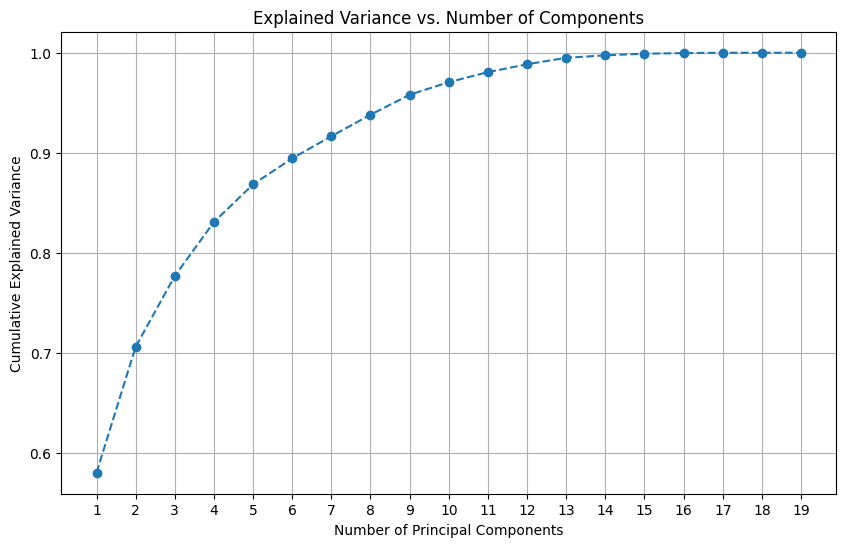

In [282]:
from sklearn.decomposition import PCA

# Initialize PCA without specifying the number of components to explore explained variance
pca = PCA()
X_FD_train_pca = pca.fit_transform(X_FD_train_scaled)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Display the cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')

# Set x-axis ticks to whole numbers
plt.xticks(np.arange(1, len(cumulative_variance) + 1, step=1))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


In [293]:
# Initialize PCA with 6 components
pca = PCA(n_components=9)

# Fit PCA on training data and transform both training and test sets
X_FD_train_pca = pca.fit_transform(X_FD_train_scaled)
X_FD_test_pca = pca.transform(X_FD_test_scaled)

# Check the transformed shapes
print("Training data after PCA:", X_FD_train_pca.shape)
print("Test data after PCA:", X_FD_test_pca.shape)


Training data after PCA: (30836, 9)
Test data after PCA: (10279, 9)


In [294]:
pca_XGB_FD = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [295]:
# Fit the best model on the training data
pca_XGB_FD.fit(X_FD_train_pca, y_FD_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [296]:
# Make predictions on the test data
y_pred = pca_XGB_FD.predict(X_FD_test_pca)

In [297]:
print(f"Base pca XGB R_squared_train: {pca_XGB_FD.score(X_FD_train_pca, y_FD_train)}")
print(f"Base pca XGB R_squared_test: {pca_XGB_FD.score(X_FD_test_pca, y_FD_test)}")
print(f"Base pca XGB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"Base pca XGB MSE: {mean_squared_error(y_FD_test, y_pred)}")
print(f"Base pca XGB RMSE: {mean_squared_error(y_FD_test, y_pred, squared=False)}")
print(f"Explained Variance by PCA components: {pca.explained_variance_ratio_.sum():.2f}")


Base pca XGB R_squared_train: 0.7349569737820627
Base pca XGB R_squared_test: 0.5618524521961819
Base pca XGB MAE: 7.979501607122125
Base pca XGB MSE: 104.04757784267457
Base pca XGB RMSE: 10.200371456112496
Explained Variance by PCA components: 0.96


C:\Users\Owner\anaconda3\envs\nba_dfs_model\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
